[View in Colaboratory](https://colab.research.google.com/github/MaxGhenis/random/blob/master/quantile_regression_comparison.ipynb)

>[Quantile regression from OLS to TensorFlow](#scrollTo=PQdJbWCS9N3G)

>>[Setup](#scrollTo=VjvK4vP2-X_D)

>>>[Data](#scrollTo=vdaqXkSCe7gG)

>>>>[Load](#scrollTo=vdaqXkSCe7gG)

>>>>[Normalize](#scrollTo=xuphFNDqtEiW)

>>>>[Make DataFrames](#scrollTo=HDT3Cs7ptIYG)

>>>[Initialize result](#scrollTo=utzAT-gdBTqj)

>>[OLS](#scrollTo=6dRLoTDhCrpO)

>>[QuantReg](#scrollTo=esTAKyTyG1TS)

>>[Random forests](#scrollTo=qCt2S4V9Uepc)

>>[Keras](#scrollTo=H55y_74W97jH)

>>>[Quantiles 0.1, 0.5, 0.9](#scrollTo=SeMIPNsO-qxI)

>>[TensorFlow](#scrollTo=PEy2M6X89tbD)

>>[Compare quantile loss](#scrollTo=42LIBXl933YI)

>>[All features](#scrollTo=ig_Wywm05sjA)

>>>[OLS](#scrollTo=ImnTiUft-Yhq)

>>>[Quantreg](#scrollTo=sC29BePy_dtj)



# Quantile regression from OLS to TensorFlow

Use the Boston housing dataset.

Based on blog posts using:
* Keras: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
* Tensorflow: https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* statsmodels quantile regression: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

## Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn import ensemble

import tensorflow as tf

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


Keras and TensorFlow options

In [0]:
EPOCHS = 2000
BATCH_SIZE = 32

### Graph options

In [3]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2018-08-21 15:25:06--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2018-08-21 15:25:06--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf.2’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.04s   

2018-08-21 15:25:

In [0]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

### Data

#### Load

In [0]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = \
    boston_housing.load_data()

#### Normalize

In [0]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

#### Make DataFrames

In [0]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

train_df = pd.DataFrame(train_data, columns=column_names)
test_df = pd.DataFrame(test_data, columns=column_names)

In [0]:
x_train = train_df.AGE
x_test = test_df.AGE

Reformat data for `statsmodels`.

In [0]:
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

Reformat data for `tensorflow`.

In [0]:
x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

### Initialize result

Dataset per method, quantile, and `x` value.

In [0]:
METHODS = ['ols', 'quantreg', 'rf', 'keras', 'tf']

METHODS_PRINT = ['OLS', 'QuantReg', 'Random forests', 'Keras', 'TensorFlow']

QUANTILES = [0.1, 0.5, 0.9]

quantiles_legend = ['10th percentile', '50th percentile', '90th percentile']

In [0]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [0]:
preds['label'] = np.resize(test_labels, preds.shape[0])

## Quantile loss example

In [0]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    e = (y - f)
    return np.maximum(q * e, (q - 1) * e)

In [0]:
quantile_loss_example_e = np.linspace(-1, 1, 1000)
quantile_loss_example_loss_10 = quantile_loss(0.1, 0, quantile_loss_example_e)
quantile_loss_example_loss_50 = quantile_loss(0.5, 0, quantile_loss_example_e)
quantile_loss_example_loss_90 = quantile_loss(0.9, 0, quantile_loss_example_e)

In [0]:
sns.set_palette(sns.color_palette('Blues', 3))
pal = sns.color_palette("coolwarm", 3)
dot_color = pal[1]
sns.set_palette(pal)
sns.set_palette(sns.color_palette('Blues', 3))

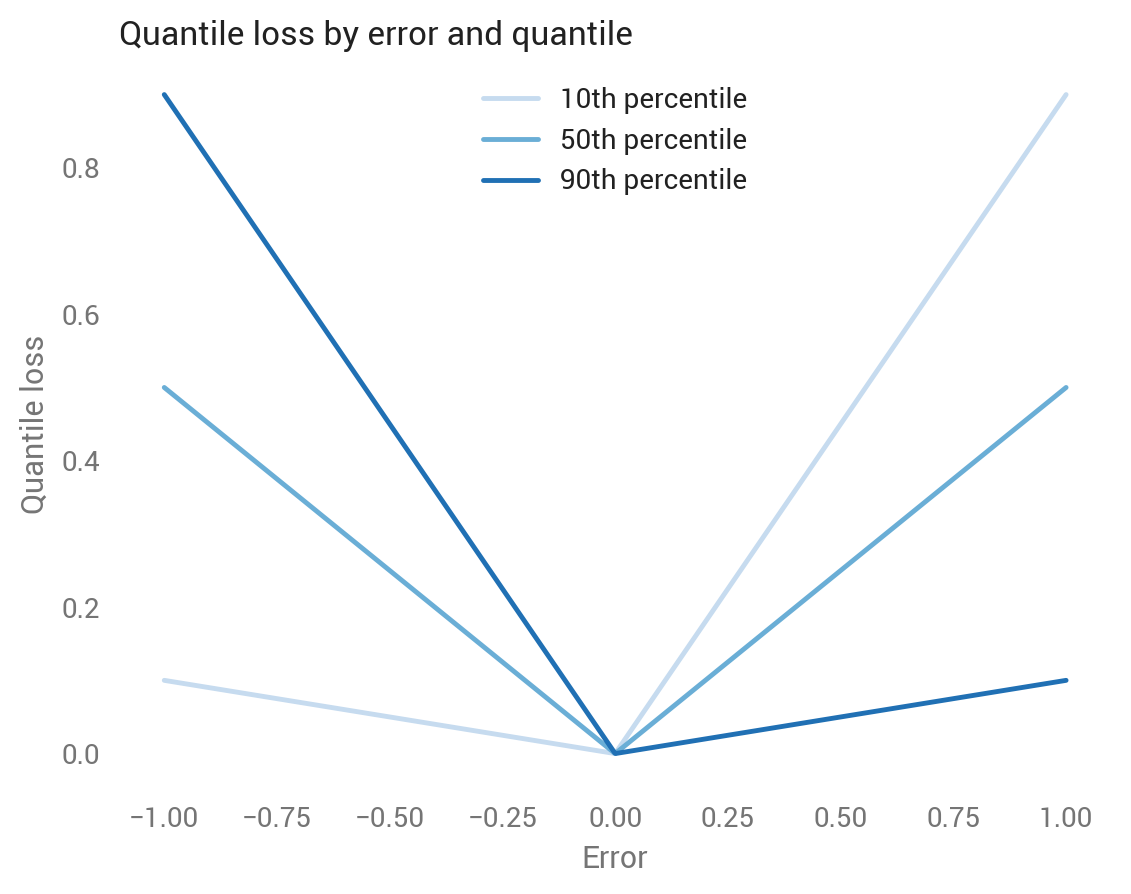

In [17]:
plt.plot(quantile_loss_example_e, quantile_loss_example_loss_10)
plt.plot(quantile_loss_example_e, quantile_loss_example_loss_50)
plt.plot(quantile_loss_example_e, quantile_loss_example_loss_90)
plt.legend(quantiles_legend)
sns.despine(left=True, bottom=True)
plt.xlabel('Error')
plt.ylabel('Quantile loss')
plt.title('Quantile loss by error and quantile', loc='left')

plt.show()

In [0]:
quantile_loss_example_q = np.linspace(0.01, 0.99, 99)
quantile_loss_example_loss_neg1 = quantile_loss(quantile_loss_example_q, 0, -1)
quantile_loss_example_loss_pos1 = quantile_loss(quantile_loss_example_q, 0, 1)

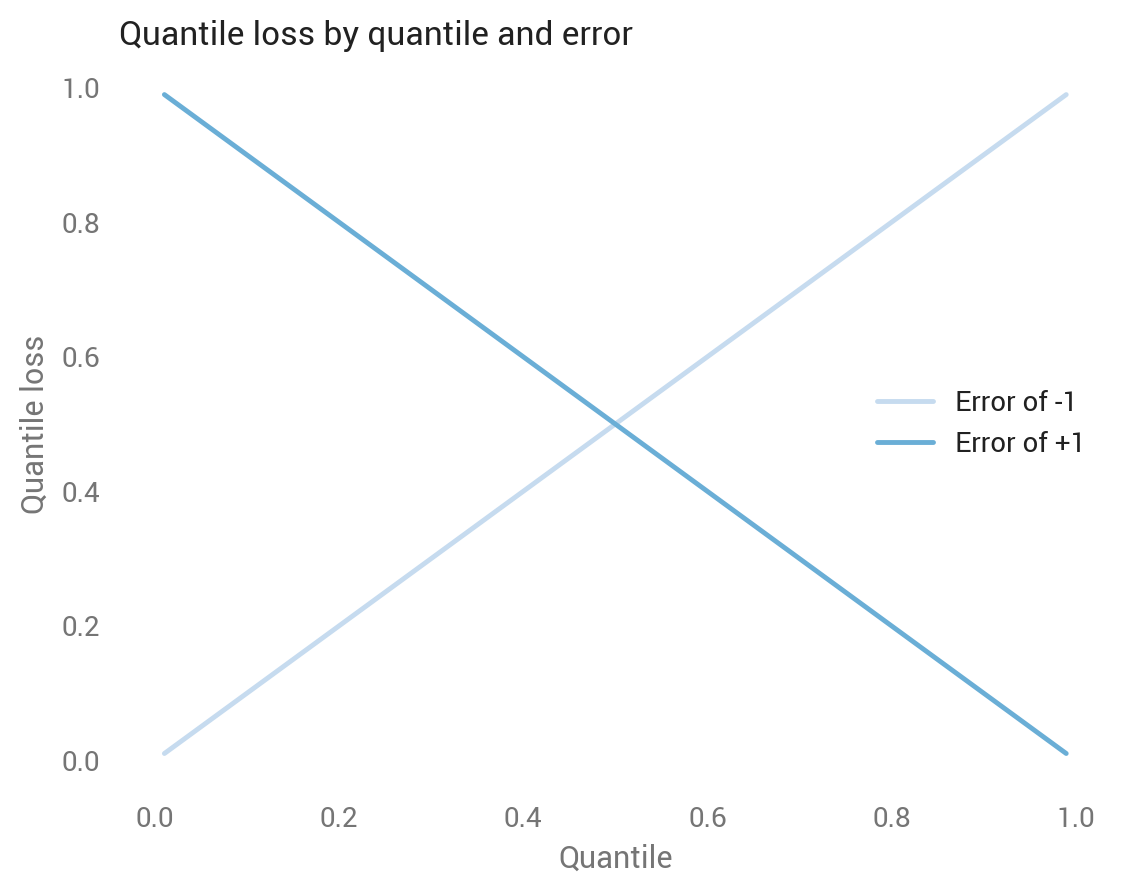

In [19]:
plt.plot(quantile_loss_example_q, quantile_loss_example_loss_neg1)
plt.plot(quantile_loss_example_q, quantile_loss_example_loss_pos1)
plt.legend(['Error of -1', 'Error of +1'])
sns.despine(left=True, bottom=True)
plt.xlabel('Quantile')
plt.ylabel('Quantile loss')
plt.title('Quantile loss by quantile and error', loc='left')

plt.show()

## OLS

https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

In [0]:
ols = sm.OLS(train_labels, X_train).fit()

In [0]:
def ols_quantile(m, X, q):
  # m: OLS model.
  # X: X matrix.
  # q: Quantile.
  #
  # Set alpha based on q.
  a = q * 2
  if q > 0.5:
    a = 2 * (1 - q)
  predictions = m.get_prediction(X)
  frame = predictions.summary_frame(alpha=a)
  if q > 0.5:
    return frame.obs_ci_upper
  return frame.obs_ci_lower

In [0]:
preds.loc[preds.method == 'ols', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES]) 

## QuantReg

https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

In [0]:
quantreg = sm.QuantReg(train_labels, X_train)  # Don't fit yet, since we'll fit once per quantile.

In [0]:
preds.loc[preds.method == 'quantreg', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

## Random forests

In [25]:
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(X_train, train_labels)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=3, verbose=True, warm_start=False)

In [0]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [0]:
preds.loc[preds.method == 'rf', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

## Keras

From https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

One area that Deep Learning has not explored extensively is the uncertainty in estimates. However, as far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. eg. For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. The uncertainty of the estimate of an individuals weight is less interesting.

### Quantiles 0.1, 0.5, 0.9

The loss for an individual data point is defined as:
$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$
where $\alpha$ is the required quantile and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model. The final overall loss is defines as:
$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

The following function defines the loss function for a quantile model.

**Note**: The following 4 lines is ALL that you change in comparison to a normal Deep Learning method, i.e. The loss function is all that changes.

In [0]:
def tilted_loss(q, y, f):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

In [0]:
def keras_pred(x_train, train_labels, x_test, q):
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(units=10, input_dim=input_dim, activation='relu'))
    model.add(Dense(units=10, input_dim=input_dim, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adadelta')
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0)
    
    # Predict the quantile
    return model.predict(x_test)

Try another way as recommended in the TF guide: https://www.tensorflow.org/tutorials/keras/basic_regression

In [0]:
# def keras_pred2(x_train, train_labels, x_test, q):
#     model = keras.Sequential(
#         keras.layers.Dense(64, activation=tf.nn.relu, 
#                        input_shape=(train_data.shape[1],)),
#     keras.layers.Dense(64, activation=tf.nn.relu),
#     keras.layers.Dense(1)
#   ])
#     model.add(Dense(units=10, input_dim=1, activation='relu'))
#     model.add(Dense(units=10, input_dim=1, activation='relu'))
#     model.add(Dense(1))
    
#     model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adadelta')
#     model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
#               verbose=0)
    
#     # Predict the quantile
#     return model.predict(x_test)

In [0]:
preds.loc[preds.method == 'keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

## TensorFlow

Adapted from https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb

In [0]:
# Initialize session
sess = tf.Session()

In [0]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                          units=32, 
                                          activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                          units=32, 
                                          activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1, 1, 
                                         name="{}_q{}".format(i, int(q * 100)))
                self.outputs.append(output)
                
                # Create losses
                
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q * error, (q - 1) * error),
                                      axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(
                self.combined_loss)

    def fit(self, x, y, epochs=100):
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]), :]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]), :]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss],
                                          feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

In [0]:
# Instantiate model
tf_model = q_model(sess, QUANTILES, batch_size=BATCH_SIZE)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [35]:
# Run training
tf_model.fit(x_train_expanded, train_labels_expanded, EPOCHS)

Epoch 0: 33.332740783691406
Epoch 100: 5.861645698547363
Epoch 200: 5.829241752624512
Epoch 300: 5.826866149902344
Epoch 400: 5.827460289001465
Epoch 500: 5.82751989364624
Epoch 600: 5.827491283416748
Epoch 700: 5.827453136444092
Epoch 800: 5.827394485473633
Epoch 900: 5.8273468017578125
Epoch 1000: 5.827236652374268
Epoch 1100: 5.82730770111084
Epoch 1200: 5.827261924743652
Epoch 1300: 5.827075004577637
Epoch 1400: 5.828164100646973
Epoch 1500: 5.8274006843566895
Epoch 1600: 5.827718734741211
Epoch 1700: 5.827560901641846
Epoch 1800: 5.827969551086426
Epoch 1900: 5.827028274536133


In [0]:
preds.loc[preds.method == 'tf', 'pred'] = \
    np.array([item for sublist in tf_model.predict(x_test_expanded)
              for item in sublist])

## Visualize quantiles

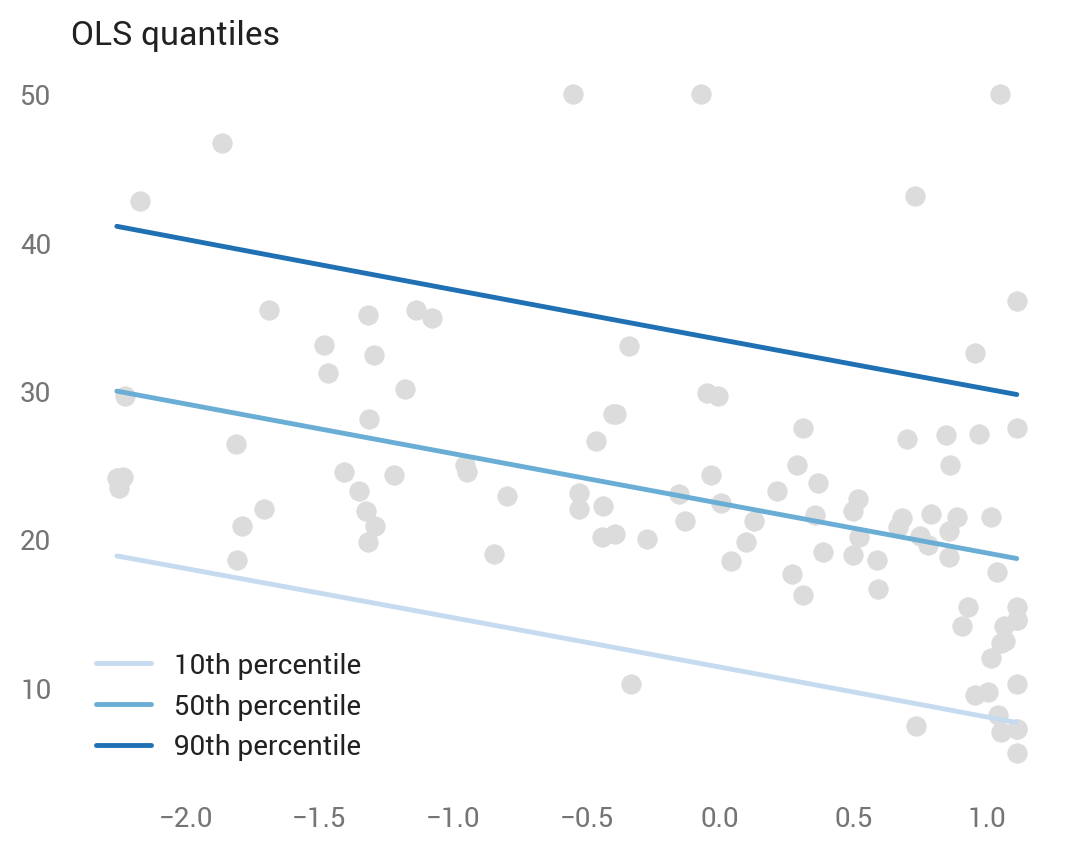

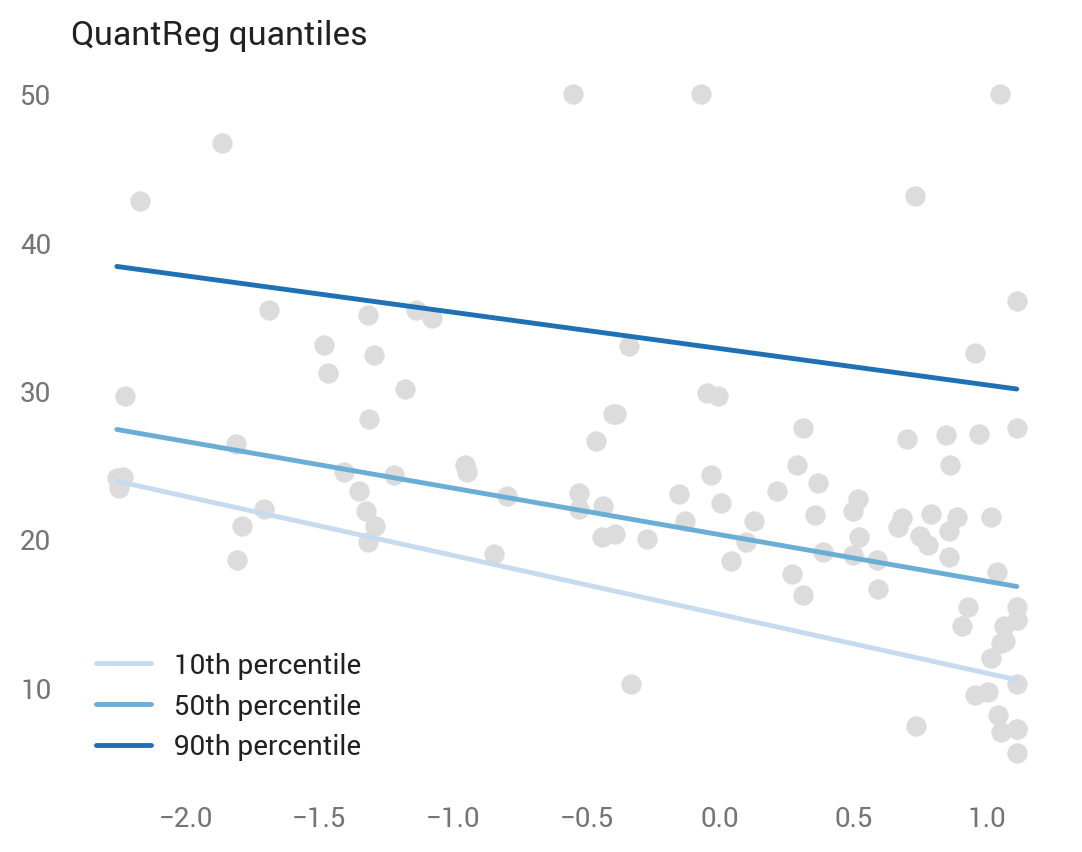

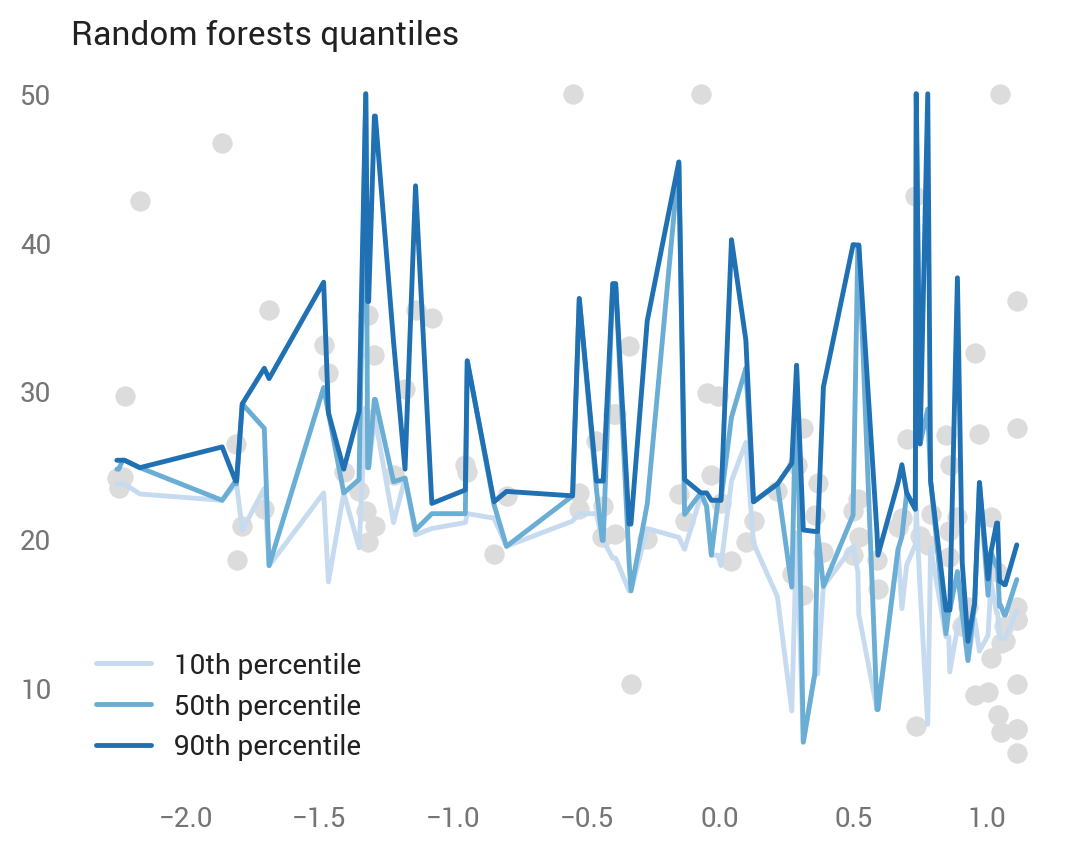

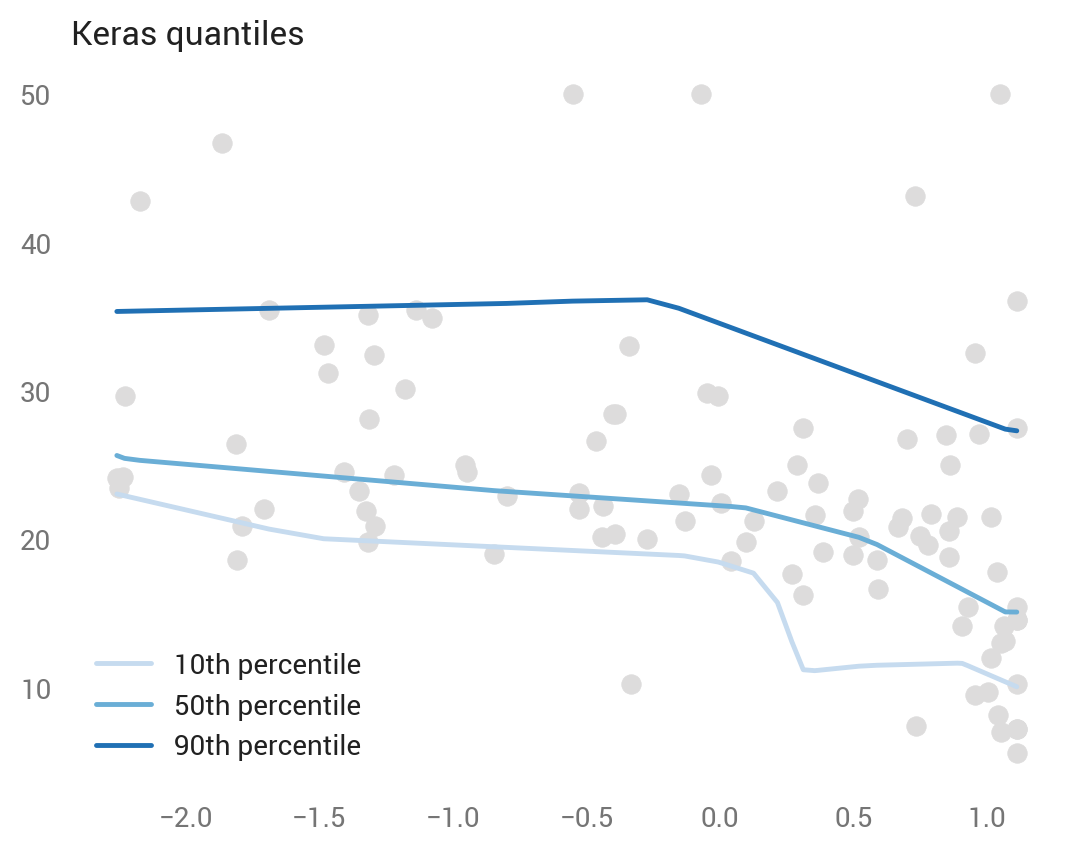

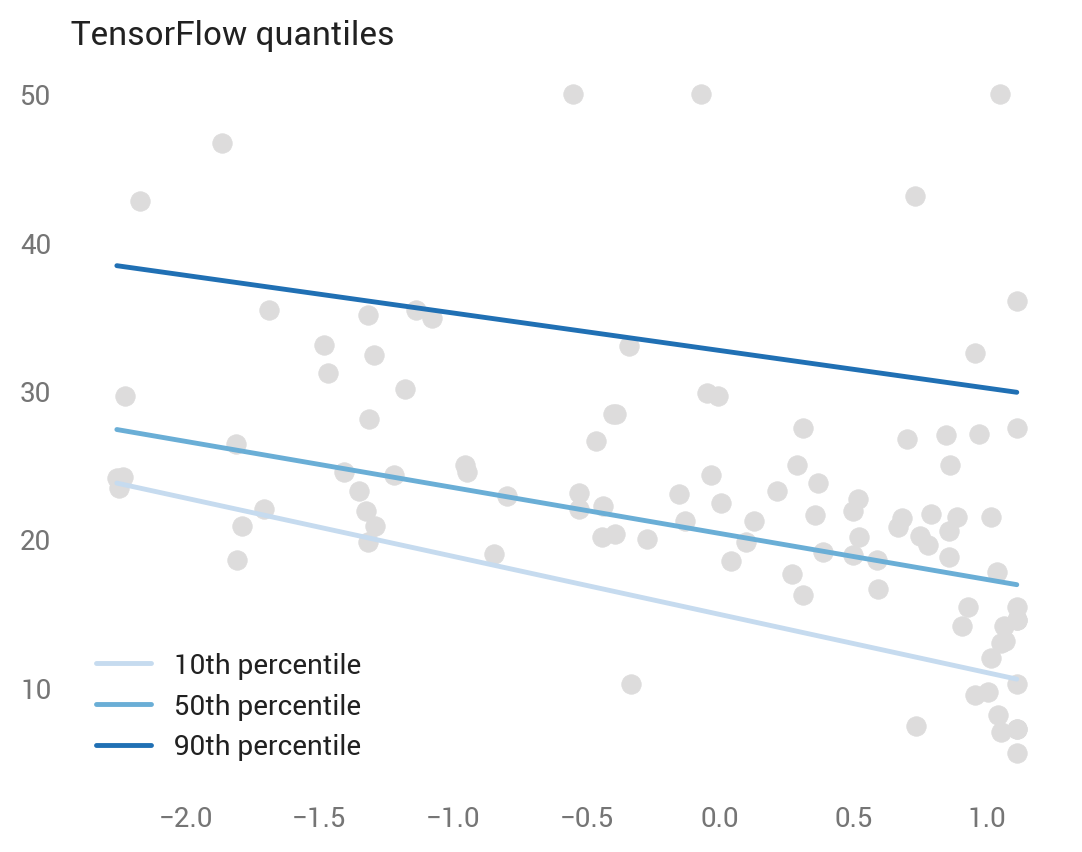

In [37]:
for i, method in enumerate(METHODS):
    plt.scatter(x_test, test_labels, color=dot_color)
    plt.plot(preds[preds.method == method].pivot_table(
        index='x', columns='q', values='pred'))
    plt.legend(quantiles_legend)
    plt.title(METHODS_PRINT[i] + ' quantiles', loc='left')
    sns.despine(left=True, bottom=True)
    plt.show()

## Compare quantile loss

In [0]:
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

In [39]:
preds.pivot_table(index='method', values='quantile_loss')

,quantile_loss
method,
keras,1.947747
ols,2.015076
quantreg,1.993945
rf,3.040444
tf,1.990712


In [40]:
preds.pivot_table(index='method', columns='q', values='quantile_loss', 
                  margins=True)

q,0.1,0.5,0.9,All
method,,,,
keras,1.105899,2.859804,1.877537,1.947747
ols,1.220711,2.970241,1.854276,2.015076
quantreg,1.150024,2.990252,1.841559,1.993945
rf,1.702751,4.085894,3.332687,3.040444
tf,1.150923,2.982485,1.838728,1.990712
All,1.266062,3.177735,2.148957,2.197585


## All features

Same analysis but using all `x` features.

In [0]:
preds_full = preds[['method', 'q', 'label']].copy(deep=True)

In [0]:
x_train_full = train_df.copy(deep=True)
x_test_full = test_df.copy(deep=True)

Reformat data for `statsmodels`.

In [0]:
X_train_full = sm.add_constant(x_train_full)
X_test_full = sm.add_constant(x_test_full)

Reformat data for `tensorflow`.

In [0]:
x_train_expanded_full = np.expand_dims(x_train_full, 1)
x_test_expanded_full = np.expand_dims(x_test_full, 1)

### OLS

In [0]:
ols_full = sm.OLS(train_labels, X_train_full).fit()

In [0]:
preds_full.loc[preds.method == 'ols', 'pred'] = np.concatenate(
    [ols_quantile(ols_full, X_test_full, q) for q in QUANTILES]) 

### Quantreg

In [0]:
# Don't fit yet, since we'll fit once per quantile.
quantreg_full = sm.QuantReg(train_labels, X_train_full)

In [0]:
preds_full.loc[preds.method == 'quantreg', 'pred'] = np.concatenate(
    [quantreg_full.fit(q=q).predict(X_test_full) for q in QUANTILES]) 

### Random forests

In [49]:
rf_full = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                         min_samples_leaf=1, random_state=3, 
                                         n_jobs=-1)
rf_full.fit(X_train_full, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)

In [0]:
preds_full.loc[preds_full.method == 'rf', 'pred'] = np.concatenate(
    [rf_quantile(rf_full, X_test_full, q) for q in QUANTILES]) 

### Keras

In [0]:
preds_full.loc[preds.method == 'keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_full, train_labels, x_test_full, q) for q in QUANTILES]) 

### TensorFlow

Getting errors, skip for now.

In [0]:
if False:
    # Instantiate model
    tf_model_full = q_model(sess, QUANTILES, batch_size=BATCH_SIZE)

    # Initialize all variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    # Run training
    tf_model_full.fit(x_train_full, train_labels_expanded, EPOCHS)
    
    tf_model_full.predict(x_test_full)
    
    preds_full.loc[preds_full.method == 'tf', 'pred'] = np.array(
        [item for sublist in tf_model_full.predict(x_test_expanded_full)
         for item in sublist]
    )

### Compare

In [0]:
preds_full['quantile_loss'] = quantile_loss(preds_full.q, preds_full.label, 
                                            preds_full.pred)

In [54]:
preds_full.pivot_table(index='method', values='quantile_loss')

,quantile_loss
method,
keras,1.029799
ols,1.175130
quantreg,1.105230
rf,0.852464
tf,NaN


In [55]:
preds_full.pivot_table(index='method', columns='q', values='quantile_loss', 
                       margins=True)

q,0.1,0.5,0.9,All
method,,,,
keras,0.771534,1.434279,0.883585,1.029799
ols,0.810617,1.732093,0.982682,1.175130
quantreg,0.638376,1.544485,1.132828,1.105230
rf,0.696186,1.203431,0.657775,0.852464
tf,NaN,NaN,NaN,NaN
All,0.729178,1.478572,0.914217,1.040656
